## Imports and Constants

In [1]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(patchwork))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(cowplot))) # figure composition
suppressPackageStartupMessages(suppressWarnings(library(RcppTOML))) # parsing config file
suppressPackageStartupMessages(suppressWarnings(library(lattice))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ComplexHeatmap))) # heatmap
suppressPackageStartupMessages(suppressWarnings(library(ggplotify))) # grob
suppressPackageStartupMessages(suppressWarnings(library(viridis))) # color
suppressPackageStartupMessages(suppressWarnings(library(platetools))) # make plate plot
suppressPackageStartupMessages(suppressWarnings(library(circlize))) 
suppressPackageStartupMessages(suppressWarnings(library(reshape2))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(stringr))) # string manipulation
suppressPackageStartupMessages(suppressWarnings(library(purrr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(VennDiagram))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(tidyverse))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggvenn))) # venn diagram
suppressPackageStartupMessages(suppressWarnings(library(grid))) # grid
suppressPackageStartupMessages(suppressWarnings(library(Polychrome)))

source("../../utils/figure_themes.r")


In [2]:
cell_type <- "PBMC"


In [3]:
# set path to anova results
anova_results_path = file.path(paste0(
    "../../../1.Exploratory_Data_Analysis/results/",cell_type,"_combined.parquet"
))
figures_path = "../figures"
if (!dir.exists(figures_path)) dir.create(figures_path)
# read in path
anova_results = arrow::read_parquet(anova_results_path)
anova_results = anova_results %>% filter(shuffled == TRUE)

In [4]:
head(anova_results)

group1,group2,meandiff,lower,upper,p-adj,reject,features,p-adj_abs,pos_neg,shuffled,__index_level_0__
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<chr>,<dbl>,<chr>,<lgl>,<int>
apoptosis,healthy,-0.0084,0.2131,-0.0263,0.0095,FALSE,Nuclei_RadialDistribution_ZernikePhase_CorrPM_1_1,0.0095,positive,TRUE,0
apoptosis,pyroptosis,-0.0093,0.1532,-0.0274,0.0087,FALSE,Nuclei_RadialDistribution_ZernikePhase_CorrPM_1_1,0.0087,positive,TRUE,1
healthy,pyroptosis,-0.0009,0.9083,-0.0090,0.0071,FALSE,Nuclei_RadialDistribution_ZernikePhase_CorrPM_1_1,0.0071,positive,TRUE,2
apoptosis,pyroptosis,0.0039,0.7181,-0.0142,0.0220,FALSE,Cytoplasm_RadialDistribution_ZernikePhase_CorrMito_7_3,0.0220,positive,TRUE,1
apoptosis,healthy,0.0022,0.9021,-0.0158,0.0201,FALSE,Cytoplasm_RadialDistribution_ZernikePhase_CorrMito_7_3,0.0201,positive,TRUE,0
healthy,pyroptosis,0.0018,0.7182,-0.0064,0.0099,FALSE,Cytoplasm_RadialDistribution_ZernikePhase_CorrMito_7_3,0.0099,positive,TRUE,2


In [5]:
# create a column that adds group1 and group2 together
anova_results$group = paste0(anova_results$group1,"_",anova_results$group2)


In [6]:
# filter out rows that have p-adj_abs > 0.05
anova_results = anova_results %>% filter(`p-adj_abs` < 0.05)


In [7]:
# change the group names to replace healhty with    control
anova_results$group = str_replace_all(anova_results$group,"healthy","control")


In [8]:
# create the three df sets for a venn diagram
a_h <- anova_results %>% filter(group == "apoptosis_control")
a_p <- anova_results %>% filter(group == "apoptosis_pyroptosis")
h_p <- anova_results %>% filter(group == "control_pyroptosis")
a_h <- a_h %>% select(features)
a_p <- a_p %>% select(features)
h_p <- h_p %>% select(features)

# create a list of the three df sets
a_h_list <- a_h %>% pull(features)
a_p_list <- a_p %>% pull(features)
h_p_list <- h_p %>% pull(features)

x=list(a_h_list,a_p_list,h_p_list)


In [9]:
length(a_h_list)
length(a_p_list)
length(h_p_list)


[1] 889

[1] 593

[1] 567

[1] TRUE

[1] "gg"     "ggplot"

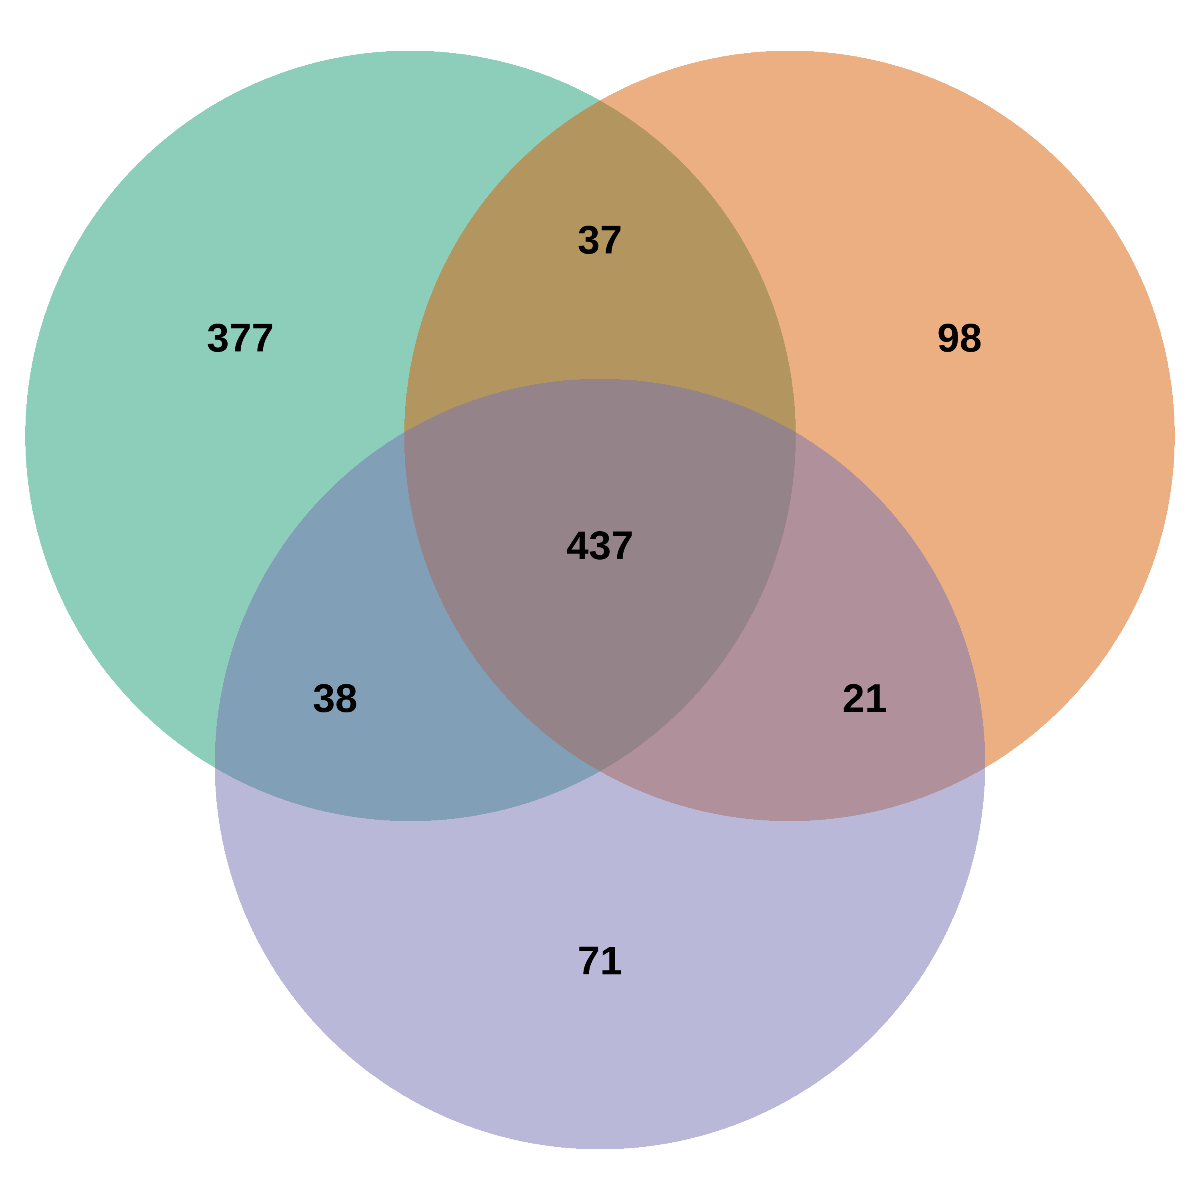

In [10]:
# set plot size 
width <- 10
height <- 10
options(repr.plot.width=width, repr.plot.height=height)
myCol <- brewer.pal(3, "Dark2")
venn_diagram_plot <- venn.diagram(
    x=x,
    show=TRUE,
    category.names = c("","",""),
    filename = paste0("../figures/",cell_type,"_venn_diagram.png"),
    # Output features
    imagetype="png" , 
    resolution = 600,
    compression = "lzw",
    
    # Circles
    lwd = 2,
    lty = 'blank',
    fill = myCol,
    
    # Numbers
    cex = 1,
    fontface = "bold",
    fontfamily = "sans",
    
    # Set names
    cat.cex = 0.8,
    cat.fontface = "bold",
    cat.default.pos = "outer",
    cat.pos = c(-26, 23, 50),
    cat.dist = c(0, 0, -0.4),
    cat.fontfamily = "sans",
    rotation = 1

)
# Set the directory path
directory <- "../figures"
# List all files in the directory
files <- list.files(directory, full.names = TRUE)
# Filter files that end with ".log"
log_files <- files[grep(".log$", files)]
# Remove the log files
file.remove(log_files)
# read in the venn diagram from PNG
venn_diagram_image_path = file.path(paste0("../figures/",cell_type,"_venn_diagram.png"))
venn_diagram_image = png::readPNG(venn_diagram_image_path)
# plot the montage image to a ggplot object
venn_diagram_image <- (
    ggplot()
    + annotation_custom(
        rasterGrob(venn_diagram_image, interpolate = TRUE),
        xmin=-Inf, xmax=Inf, ymin=-Inf, ymax=Inf
    )
    + theme_void()
)
# get the type of the object
class(venn_diagram_image)
venn_diagram_image



In [11]:
sessionInfo()

R version 4.2.2 (2022-10-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Pop!_OS 22.04 LTS

Matrix products: default
BLAS/LAPACK: /home/lippincm/miniforge3/envs/Interstellar_R/lib/libopenblasp-r0.3.27.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Polychrome_1.5.1      ggvenn_0.1.10         forcats_1.0.0        
 [4] readr_2.1.5           tidyr_1.3.1           tibble_3.2.1         
 [7] tidyverse_1.3.2       VennDiagram_1.7.3     futile.logger_1.4.3  
[10] purrr_1.0.2           stringr_1.5.1         reshape2_1.4.4     